In [ ]:
#Differential privacy and homomorphic encryption mechanism on  NYC-Taxi dataset

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time
import os
import kaggle
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import dask.dataframe as dd
import dask.multiprocessing

# Configure Dask for parallel processing
dask.config.set(scheduler='processes')

In [11]:
# data cleaning and preprocessing

class DataHandler:
    def __init__(self, data_path=None):
        self.data_path = data_path or "./data"
        os.makedirs(self.data_path, exist_ok=True)
        self.chunk_size = 1000000  # 1M rows per chunk
        self.required_columns = [
            'trip_distance', 'fare_amount', 'passenger_count',
            'payment_type', 'PULocationID', 'DOLocationID', 'tpep_pickup_datetime'
        ]

    def download_dataset(self):
        """Attempt dataset download from multiple sources"""
        if not self._verify_kaggle_credentials():
            self._alternative_download()
        else:
            try:
                self._download_via_kaggle()
                if not self._validate_downloaded_data():
                    self._alternative_download()
            except Exception as e:
                print(f"Kaggle download failed: {e}")
                self._alternative_download()

    def _verify_kaggle_credentials(self):
        """Check for valid Kaggle credentials"""
        kaggle_dir = os.path.expanduser('~/.kaggle')
        if not os.path.exists(os.path.join(kaggle_dir, 'kaggle.json')):
            print("""\nKaggle API credentials not found!
            Follow these steps:
            1. Go to https://www.kaggle.com/<your-username>/account
            2. Create API token (download kaggle.json)
            3. Place kaggle.json in:
               - Windows: C:\\Users\\<user>\\.kaggle\\ 
               - Linux/Mac: ~/.kaggle/
            4. Run: chmod 600 ~/.kaggle/kaggle.json""")
            return False
        return True

    def _download_via_kaggle(self):
        """Download dataset using Kaggle API"""
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(
            'mathchi/nyc-taxi-trip-data',
            path=self.data_path,
            unzip=True,
            force=True
        )
        print("Kaggle dataset downloaded and extracted")

    def _alternative_download(self):
        """Fallback direct download from TLC S3 bucket"""
        print("Downloading from NYC TLC S3 source...")
        base_url = "https://s3.amazonaws.com/nyc-tlc/trip+data/"
        files = [f"yellow_tripdata_{year}-{month:02d}.csv" 
                for year in range(2019, 2023) 
                for month in range(1, 13)]
        
        existing_files = glob.glob(os.path.join(self.data_path, "yellow_tripdata_*.csv"))
        existing_filenames = [os.path.basename(f) for f in existing_files]
        
        for file in tqdm(files, desc="Downloading files"):
            if file not in existing_filenames:
                url = f"{base_url}{file}"
                dest = os.path.join(self.data_path, file)
                os.system(f"curl -# -o {dest}.tmp {url} && mv {dest}.tmp {dest}")

    def load_data(self, sample_size=None):
        """Load data with Dask for parallel processing"""
        if self._has_any_real_data():
            return self._load_real_data(sample_size)
        return self._generate_synthetic_data(sample_size or 100000)

    def _has_any_real_data(self):
        """Check for existing data files"""
        return len(glob.glob(os.path.join(self.data_path, "yellow_tripdata_*.csv"))) > 0

    def _load_real_data(self, sample_size):
        """Load and process real data using Dask"""
        files = glob.glob(os.path.join(self.data_path, "yellow_tripdata_*.csv"))
        ddf = dd.read_csv(
            files,
            usecols=self.required_columns,
            parse_dates=['tpep_pickup_datetime'],
            blocksize="256MB"
        )
        
        # Preprocessing
        ddf = ddf.map_partitions(self._preprocess_data)
        
        # Convert to pandas if sample requested
        if sample_size:
            return ddf.sample(frac=sample_size/len(ddf)).compute()
        return ddf.compute()

    def _preprocess_data(self, df):
        """Data cleaning and feature engineering"""
        # Create target variable
        df['target'] = (df['trip_distance'] > 3).astype('int8')
        
        # Handle missing values
        df['passenger_count'] = df['passenger_count'].fillna(1).clip(1, 6)
        df['payment_type'] = df['payment_type'].fillna(1)
        
        # Temporal features
        df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour.astype('int8')
        df['pickup_day'] = df['tpep_pickup_datetime'].dt.dayofweek.astype('int8')
        
        # Optimize memory
        return df.astype({
            'trip_distance': 'float32',
            'fare_amount': 'float32',
            'payment_type': 'int8',
            'PULocationID': 'int16',
            'DOLocationID': 'int16'
        })

    def _generate_synthetic_data(self, sample_size):  # CORRECTED METHOD NAME
        """Generate realistic synthetic taxi data"""
        np.random.seed(42)
        n_samples = sample_size
        
        return pd.DataFrame({
            'trip_distance': np.abs(np.random.normal(3.5, 2.5, n_samples)).astype('float32'),
            'fare_amount': np.abs(np.random.normal(15, 8, n_samples)).astype('float32'),
            'passenger_count': np.random.randint(1, 6, n_samples).astype('int8'),
            'payment_type': np.random.choice([1, 2, 3, 4], n_samples).astype('int8'),
            'PULocationID': np.random.randint(1, 265, n_samples).astype('int16'),
            'DOLocationID': np.random.randint(1, 265, n_samples).astype('int16'),
            'target': (np.random.random(n_samples) > 0.65).astype('int8')
        })

    def show_clean_data(self, sample_size=5, show_stats=True):
   
    # Load and preprocess data
        data = self.load_data(sample_size=10000)  # Load small sample for demonstration
        
        # Display sample data
        print(f"\n{'='*40}")
        print("Cleaned Data Sample:")
        print(f"{'='*40}")
        print(data.head(sample_size))
    
        # Show preprocessing statistics
        if show_stats:
            print(f"\n{'='*40}")
            print("Preprocessing Report:")
            print(f"{'='*40}")
            
            # Missing values handling report
            original_missing = data.isna().sum().sum()
            print(f"Missing values handled: {original_missing} → 0")
            
            # Data type optimization
            dtypes = data.dtypes
            print("\nOptimized Data Types:")
            print(dtypes[dtypes != 'object'])
            
            # Feature engineering info
            print("\n")
            print(f"- target: Binary classification (trip_distance > 3 miles)")
            print(f"- pickup_hour: Extracted from tpep_pickup_datetime")
            print(f"- pickup_day: Day of week from tpep_pickup_datetime")
            
            # Memory usage
            mem_usage = data.memory_usage(deep=True).sum() / 1024**2  # MB
            print(f"\nMemory Usage: {mem_usage:.2f} MB")
    
        return data


In [12]:
dh = DataHandler()

dh.show_clean_data()


Cleaned Data Sample:
   trip_distance  fare_amount  passenger_count  payment_type  PULocationID  \
0       4.741786     9.572042                1             2           218   
1       3.154339    12.556005                2             4           194   
2       5.119221    10.220951                1             4            43   
3       7.307575    15.883345                4             3           124   
4       2.914617    24.577429                3             1            20   

   DOLocationID  target  
0            22       0  
1            42       1  
2           204       1  
3           155       1  
4            11       1  

Preprocessing Report:
Missing values handled: 0 → 0

Optimized Data Types:
trip_distance      float32
fare_amount        float32
passenger_count       int8
payment_type          int8
PULocationID         int16
DOLocationID         int16
target                int8
dtype: object


- target: Binary classification (trip_distance > 3 miles)
- pickup_hour:

,trip_distance,fare_amount,passenger_count,payment_type,PULocationID,DOLocationID,target
0,4.741786,9.572042,1,2,218,22,0
1,3.154339,12.556005,2,4,194,42,1
2,5.119221,10.220951,1,4,43,204,1
3,7.307575,15.883345,4,3,124,155,1
4,2.914617,24.577429,3,1,20,11,1
...,...,...,...,...,...,...,...
9995,6.752755,18.102619,4,1,65,27,0
9996,1.495862,26.018932,5,3,104,36,1
9997,1.736708,18.026833,5,1,66,70,0
9998,4.739414,28.708239,3,1,183,185,0


In [13]:
#DP

class DifferentialPrivacy:
    def laplace_mechanism(self, data, epsilon, sensitivity=1.0):
        if isinstance(data, pd.DataFrame):
            result = data.copy()
            num_cols = [c for c in result.select_dtypes(include=[np.number]).columns 
                      if c not in ['target', 'passenger_count']]
            
            for col in num_cols:
                scale = sensitivity / epsilon
                noise = np.random.laplace(0, scale, len(result))
                result[col] = result[col] + noise.astype(result[col].dtype)
            
            return result
        else:
            scale = sensitivity / epsilon
            return data + np.random.laplace(0, scale, size=np.shape(data))

    def exponential_mechanism(self, data, utility_function, epsilon, sensitivity=1.0):
        if isinstance(data, pd.DataFrame):
            # Calculate utility scores
            scores = utility_function(data)
            
            # Calculate probabilities with numerical stability
            probabilities = np.exp(epsilon * (scores - scores.max()) / (2 * sensitivity))
            probabilities = probabilities / probabilities.sum()
            
            # Ensure valid probability distribution
            probabilities = np.nan_to_num(probabilities, nan=1/len(data))
            probabilities = np.clip(probabilities, 1e-10, 1.0)
            probabilities /= probabilities.sum()  # Re-normalize
            
            # Handle potential floating point precision issues
            try:
                indices = np.random.choice(
                    len(data), 
                    size=len(data), 
                    p=probabilities,
                    replace=True
                )
            except ValueError:
                # Fallback to uniform sampling if probabilities still invalid
                indices = np.random.choice(len(data), size=len(data), replace=True)
                
            return data.iloc[indices].reset_index(drop=True)
        else:
            raise ValueError("Exponential mechanism supports DataFrames only")

In [14]:
# HE
class HomomorphicEncryption:
    def __init__(self):
        self.batch_size = 10000
    
    def simulate_bfv(self, data):
        if isinstance(data, pd.DataFrame):
            result = data.copy()
            num_cols = result.select_dtypes(include=[np.number]).columns
            
            for col in num_cols:
                result[col] = (result[col].round() 
                              + np.random.randint(-1, 2, len(result))).astype('int32')
            
            result.attrs['encryption'] = 'bfv_simulated'
            return result
        else:
            return np.round(data).astype(int) + np.random.randint(-1, 2, data.shape)

    def batch_process(self, data, method='bfv'):
        if isinstance(data, pd.DataFrame):
            batches = [data.iloc[i:i+self.batch_size] 
                      for i in range(0, len(data), self.batch_size)]
            
            processed = [self.simulate_bfv(batch) for batch in batches]
            return pd.concat(processed)
        else:
            batches = np.array_split(data, len(data)//self.batch_size)
            processed = [self.simulate_bfv(batch) for batch in batches]
            return np.concatenate(processed)


In [15]:
#Evalution matrics
class EvaluationMetrics:
    def __init__(self):
        self.cache = {}

    def performance_metrics(self, func, *args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start
        
        mem_usage = None
        if isinstance(result, pd.DataFrame):
            mem_usage = result.memory_usage(deep=True).sum() / 1e6
        elif isinstance(result, np.ndarray):
            mem_usage = result.nbytes / 1e6
            
        return {
            'time': elapsed,
            'memory': mem_usage,
            'result': result
        }

    def privacy_metrics(self, original, private):
        metrics = {}
        num_cols = original.select_dtypes(include=np.number).columns
        
        # MSE-based distortion
        mse_values = [mean_squared_error(original[col], private[col]) 
                     for col in num_cols]
        metrics['distortion'] = np.mean(mse_values)
        
        # KL divergence
        kl_values = []
        for col in num_cols:
            bins = np.histogram_bin_edges(original[col], bins='auto')
            p = np.histogram(original[col], bins=bins, density=True)[0] + 1e-10
            q = np.histogram(private[col], bins=bins, density=True)[0] + 1e-10
            kl = np.sum(p * np.log(p / q))
            kl_values.append(kl)
        metrics['kl_divergence'] = np.nanmean(kl_values)
        
        return metrics

    def utility_metrics(self, original, private, target='target'):
        metrics = {}
        features = original.columns.difference([target, 'tpep_pickup_datetime'])
        
        # Model accuracy
        X_train_priv, X_test_priv, y_train, y_test = train_test_split(
            private[features], original[target], test_size=0.3, random_state=42
        )
        
        model = RandomForestClassifier(n_estimators=20, n_jobs=-1)
        model.fit(X_train_priv, y_train)
        metrics['accuracy'] = model.score(X_test_priv, y_test)
        
        # Query errors
        errors = []
        for col in features[:5]:
            orig_mean = original[col].mean()
            priv_mean = private[col].mean()
            errors.append(abs(orig_mean - priv_mean)/orig_mean)
            
            orig_sum = original[col].sum()
            priv_sum = private[col].sum()
            errors.append(abs(orig_sum - priv_sum)/orig_sum)
            
            orig_med = original[col].median()
            priv_med = private[col].median()
            errors.append(
                abs((original[col] > orig_med).sum() - 
                   (private[col] > priv_med).sum()) / len(original)
            )
        
        metrics['query_error'] = np.mean(errors)
        return metrics


In [37]:
#privacy comparision util
class PrivacyUtilitySystem:
    def __init__(self):
        self.data_handler = DataHandler()
        self.dp = DifferentialPrivacy()
        self.he = HomomorphicEncryption()
        self.evaluator = EvaluationMetrics()
        self.results = {
            'dp_laplace': {}, 
            'dp_exponential': {},
            'he_bfv': {},
            'he_batch': {}
        }

    def _generate_report(self):
        print("\nGenerating business-friendly report...")
        report_maker = NonTechnicalReportGenerator(
            self.results,
            self.data_handler.load_data(1000)  # Sample data for demo
        )
        report = report_maker.generate_report()
        
        # Print report to console
        print('\n'.join(report))
        return report

    def get_data_comparison(self, num_samples=100):
        """Return DataFrame comparing raw vs protected samples"""
        raw_data = self.data_handler.load_data(10000)
        dp_data = self.dp.laplace_mechanism(raw_data, 1.0)
        he_data = self.he.simulate_bfv(raw_data)
        
        comparison = []
        columns = []
        
        for idx in range(num_samples):
            original = raw_data.iloc[idx][['trip_distance', 'fare_amount', 'passenger_count']]
            dp = dp_data.iloc[idx][['trip_distance', 'fare_amount', 'passenger_count']]
            he = he_data.iloc[idx][['trip_distance', 'fare_amount', 'passenger_count']]
            
            comparison.append({
                'Original': original.to_dict(),
                'DP Protected': dp.round(2).to_dict(),
                'HE Encrypted': he.astype(int).to_dict()
            })
        
        # Create multi-index DataFrame
        df = pd.DataFrame({
            ('Original', 'Trip Distance'): [x['Original']['trip_distance'] for x in comparison],
            ('Original', 'Fare Amount'): [x['Original']['fare_amount'] for x in comparison],
            ('Original', 'Passengers'): [x['Original']['passenger_count'] for x in comparison],
            ('DP Protected', 'Trip Distance'): [x['DP Protected']['trip_distance'] for x in comparison],
            ('DP Protected', 'Fare Amount'): [x['DP Protected']['fare_amount'] for x in comparison],
            ('DP Protected', 'Passengers'): [x['DP Protected']['passenger_count'] for x in comparison],
            ('HE Encrypted', 'Trip Distance'): [x['HE Encrypted']['trip_distance'] for x in comparison],
            ('HE Encrypted', 'Fare Amount'): [x['HE Encrypted']['fare_amount'] for x in comparison],
            ('HE Encrypted', 'Passengers'): [x['HE Encrypted']['passenger_count'] for x in comparison],
        })
        
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        return df

    def run_evaluation(self, sample_size=None, epsilons=[0.1, 0.5, 1.0, 2.0, 5.0]):
        print("Initializing evaluation framework...")
        self.data_handler.download_dataset()
        
        try:
            data = self.data_handler.load_data(sample_size)
            print(f"Loaded dataset: {data.shape[0]:,} rows, {data.shape[1]} columns")
        except Exception as e:
            print(f"Data loading failed: {e}")
            return None

        # Define stabilized utility function with numerical safeguards
        def utility_fn(df):
            values = df['fare_amount'].values
            centered = values - values.mean()
            centered = np.clip(centered, -1e5, 1e5)  # Prevent extreme values
            return 1 / (1 + np.abs(centered))

        # DP Evaluation with enhanced stability
        print("\nEvaluating Differential Privacy Mechanisms")
        for eps in tqdm(epsilons, desc="Laplace Mechanism"):
            try:
                perf = self.evaluator.performance_metrics(
                    self.dp.laplace_mechanism, data, eps
                )
                private = perf['result']
                
                self.results['dp_laplace'][eps] = {
                    'privacy': self.evaluator.privacy_metrics(data, private),
                    'utility': self.evaluator.utility_metrics(data, private),
                    'performance': (perf['time'], perf['memory'])
                }
            except Exception as e:
                print(f"Skipped ε={eps} due to error: {str(e)}")
                continue

        # Exponential mechanism with numerical stability
        print("\nEvaluating Exponential Mechanism")
        for eps in tqdm(epsilons, desc="Exponential Mechanism"):
            try:
                perf = self.evaluator.performance_metrics(
                    self.dp.exponential_mechanism, data, utility_fn, eps
                )
                private = perf['result']
                
                self.results['dp_exponential'][eps] = {
                    'privacy': self.evaluator.privacy_metrics(data, private),
                    'utility': self.evaluator.utility_metrics(data, private),
                    'performance': (perf['time'], perf['memory'])
                }
            except Exception as e:
                print(f"Skipped ε={eps} due to error: {str(e)}")
                continue

        # HE Evaluation with memory safeguards
        print("\nEvaluating Homomorphic Encryption")
        try:
            # Standard HE
            perf = self.evaluator.performance_metrics(
                self.he.simulate_bfv, data
            )
            self.results['he_bfv'] = {
                'privacy': self.evaluator.privacy_metrics(data, perf['result']),
                'utility': self.evaluator.utility_metrics(data, perf['result']),
                'performance': (perf['time'], perf['memory'])
            }
            
            # Batched HE with automatic memory adjustment
            try:
                perf = self.evaluator.performance_metrics(
                    self.he.batch_process, data
                )
            except MemoryError:
                self.he.batch_size = 1000  # Reduce batch size
                perf = self.evaluator.performance_metrics(
                    self.he.batch_process, data
                )
                
            self.results['he_batch'] = {
                'privacy': self.evaluator.privacy_metrics(data, perf['result']),
                'utility': self.evaluator.utility_metrics(data, perf['result']),
                'performance': (perf['time'], perf['memory'])
            }
        except Exception as e:
            print(f"Homoorphic encryption failed: {str(e)}")

        # Generate report with error handling
        try:
            self._generate_report()
        except Exception as e:
            print(f"Report generation failed: {str(e)}")
        
        return self.results

    def _evaluate_dp_mechanisms(self, data, epsilons):
        print("\nEvaluating Differential Privacy Mechanisms")
        
        # Laplace mechanism
        for eps in tqdm(epsilons, desc="Laplace Mechanism"):
            perf = self.evaluator.performance_metrics(
                self.dp.laplace_mechanism, data, eps
            )
            private = perf['result']
            
            self.results['dp_laplace'][eps] = {
                'privacy': self.evaluator.privacy_metrics(data, private),
                'utility': self.evaluator.utility_metrics(data, private),
                'performance': (perf['time'], perf['memory'])
            }
        
        # Exponential mechanism
        utility_fn = lambda df: 1 / (1 + (df['fare_amount'] - df['fare_amount'].mean())**2)
        for eps in tqdm(epsilons, desc="Exponential Mechanism"):
            perf = self.evaluator.performance_metrics(
                self.dp.exponential_mechanism, data, utility_fn, eps
            )
            private = perf['result']
            
            self.results['dp_exponential'][eps] = {
                'privacy': self.evaluator.privacy_metrics(data, private),
                'utility': self.evaluator.utility_metrics(data, private),
                'performance': (perf['time'], perf['memory'])
            }

    def _evaluate_homomorphic_encryption(self, data):
        print("\nEvaluating Homomorphic Encryption")
        
        # Standard HE
        perf = self.evaluator.performance_metrics(
            self.he.simulate_bfv, data
        )
        self.results['he_bfv'] = {
            'privacy': self.evaluator.privacy_metrics(data, perf['result']),
            'utility': self.evaluator.utility_metrics(data, perf['result']),
            'performance': (perf['time'], perf['memory'])
        }
        
        # Batched HE
        perf = self.evaluator.performance_metrics(
            self.he.batch_process, data
        )
        self.results['he_batch'] = {
            'privacy': self.evaluator.privacy_metrics(data, perf['result']),
            'utility': self.evaluator.utility_metrics(data, perf['result']),
            'performance': (perf['time'], perf['memory'])
        }

    def _generate_report(self):
        print("\n=== Evaluation Report ===")
        
        # DP Results
        print("\nDifferential Privacy Results:")
        for eps, metrics in self.results['dp_laplace'].items():
            print(f"ε={eps}:")
            print(f"  Distortion: {metrics['privacy']['distortion']:.4f}")
            print(f"  Accuracy: {metrics['utility']['accuracy']:.4f}")
            print(f"  Time: {metrics['performance'][0]:.2f}s")
        
        # HE Results
        print("\nHomomorphic Encryption Results:")
        for method in ['he_bfv', 'he_batch']:
            metrics = self.results[method]
            print(f"{method}:")
            print(f"  Query Error: {metrics['utility']['query_error']:.4f}")
            print(f"  Memory Usage: {metrics['performance'][1]:.2f}MB")
        
        # Visualization
        self._plot_results()

    def _plot_results(self):
        plt.figure(figsize=(18, 12))  # Increased figure size
        
        # ====================== 
        # Plot 1: DP Tradeoff (Top-Left)
        # ======================
        plt.subplot(231)  # 2x3 grid, position 1
        epsilons = list(self.results['dp_laplace'].keys())
        distortion = [m['privacy']['distortion'] for m in self.results['dp_laplace'].values()]
        accuracy = [m['utility']['accuracy'] for m in self.results['dp_laplace'].values()]
        
        plt.semilogx(epsilons, distortion, 'b-o', label='Distortion')
        plt.semilogx(epsilons, accuracy, 'g-s', label='Accuracy')
        plt.xlabel('Epsilon (log scale)')
        plt.title('Differential Privacy Tradeoff')
        plt.legend()
    
        # ====================== 
        # Plot 2: HE Query Error & Memory (Top-Middle)
        # ======================
        plt.subplot(232)  # 2x3 grid, position 2
        labels = ['HE BFV', 'HE Batch']
        query_errors = [
            self.results['he_bfv']['utility']['query_error'],
            self.results['he_batch']['utility']['query_error']
        ]
        memory_usages = [
            self.results['he_bfv']['performance'][1],
            self.results['he_batch']['performance'][1]
        ]
        
        ax1 = plt.gca()
        ax1_twin = ax1.twinx()
        ax1.bar(labels, query_errors, color='b', alpha=0.6, label='Query Error')
        ax1_twin.plot(labels, memory_usages, 'r-o', label='Memory Usage')
        ax1.set_xlabel('Encryption Method')
        ax1.set_ylabel('Query Error', color='b')
        ax1_twin.set_ylabel('Memory Usage (MB)', color='r')
        ax1.set_title('HE: Query Error & Memory Usage')
        ax1.legend(loc='upper left')
        ax1_twin.legend(loc='upper right')
    
        # ====================== 
        # Plot 3: HE Computation Time (Top-Right)
        # ======================
        plt.subplot(233)  # 2x3 grid, position 3
        computation_times_he = [
            self.results['he_bfv']['performance'][0],
            self.results['he_batch']['performance'][0]
        ]
        plt.bar(labels, computation_times_he, color='g', alpha=0.6)
        plt.xlabel('Encryption Method')
        plt.ylabel('Computation Time (sec)')
        plt.title('HE: Computation Time')
    
        # ====================== 
        # Plot 4: Cross-Method Time Comparison (Bottom Span)
        # ======================
        plt.subplot(212)  # Bottom half of the figure
        methods = ['DP Laplace', 'DP Exponential', 'HE BFV', 'HE Batch']
        times = [
            np.mean([m['performance'][0] for m in self.results['dp_laplace'].values()]),
            np.mean([m['performance'][0] for m in self.results['dp_exponential'].values()]),
            self.results['he_bfv']['performance'][0],
            self.results['he_batch']['performance'][0]
        ]
        plt.bar(methods, times, color=['purple', 'orange', 'g', 'darkgreen'])
        plt.ylabel('Time (s)')
        plt.title('Overall Computation Time Comparison')
        plt.xticks(rotation=45)
    
        plt.tight_layout()
        plt.savefig('full_report.png')
        plt.show()

Initializing evaluation framework...
Dataset URL: https://www.kaggle.com/datasets/mathchi/nyc-taxi-trip-data
Kaggle download failed: 403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/download/mathchi/nyc-taxi-trip-data?raw=false


Loaded dataset: 100,000 rows, 7 columns

Evaluating Differential Privacy Mechanisms


Laplace Mechanism: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]



Evaluating Exponential Mechanism


Exponential Mechanism: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]



Evaluating Homomorphic Encryption

=== Evaluation Report ===

Differential Privacy Results:
ε=0.1:
  Distortion: 113.1404
  Accuracy: 0.6201
  Time: 0.01s
ε=0.5:
  Distortion: 4.9116
  Accuracy: 0.6187
  Time: 0.01s
ε=1.0:
  Distortion: 1.1101
  Accuracy: 0.6191
  Time: 0.01s
ε=2.0:
  Distortion: 0.2314
  Accuracy: 0.6198
  Time: 0.01s
ε=5.0:
  Distortion: 0.0258
  Accuracy: 0.6180
  Time: 0.02s

Homomorphic Encryption Results:
he_bfv:
  Query Error: 0.0021
  Memory Usage: 2.80MB
he_batch:
  Query Error: 0.0017
  Memory Usage: 2.80MB


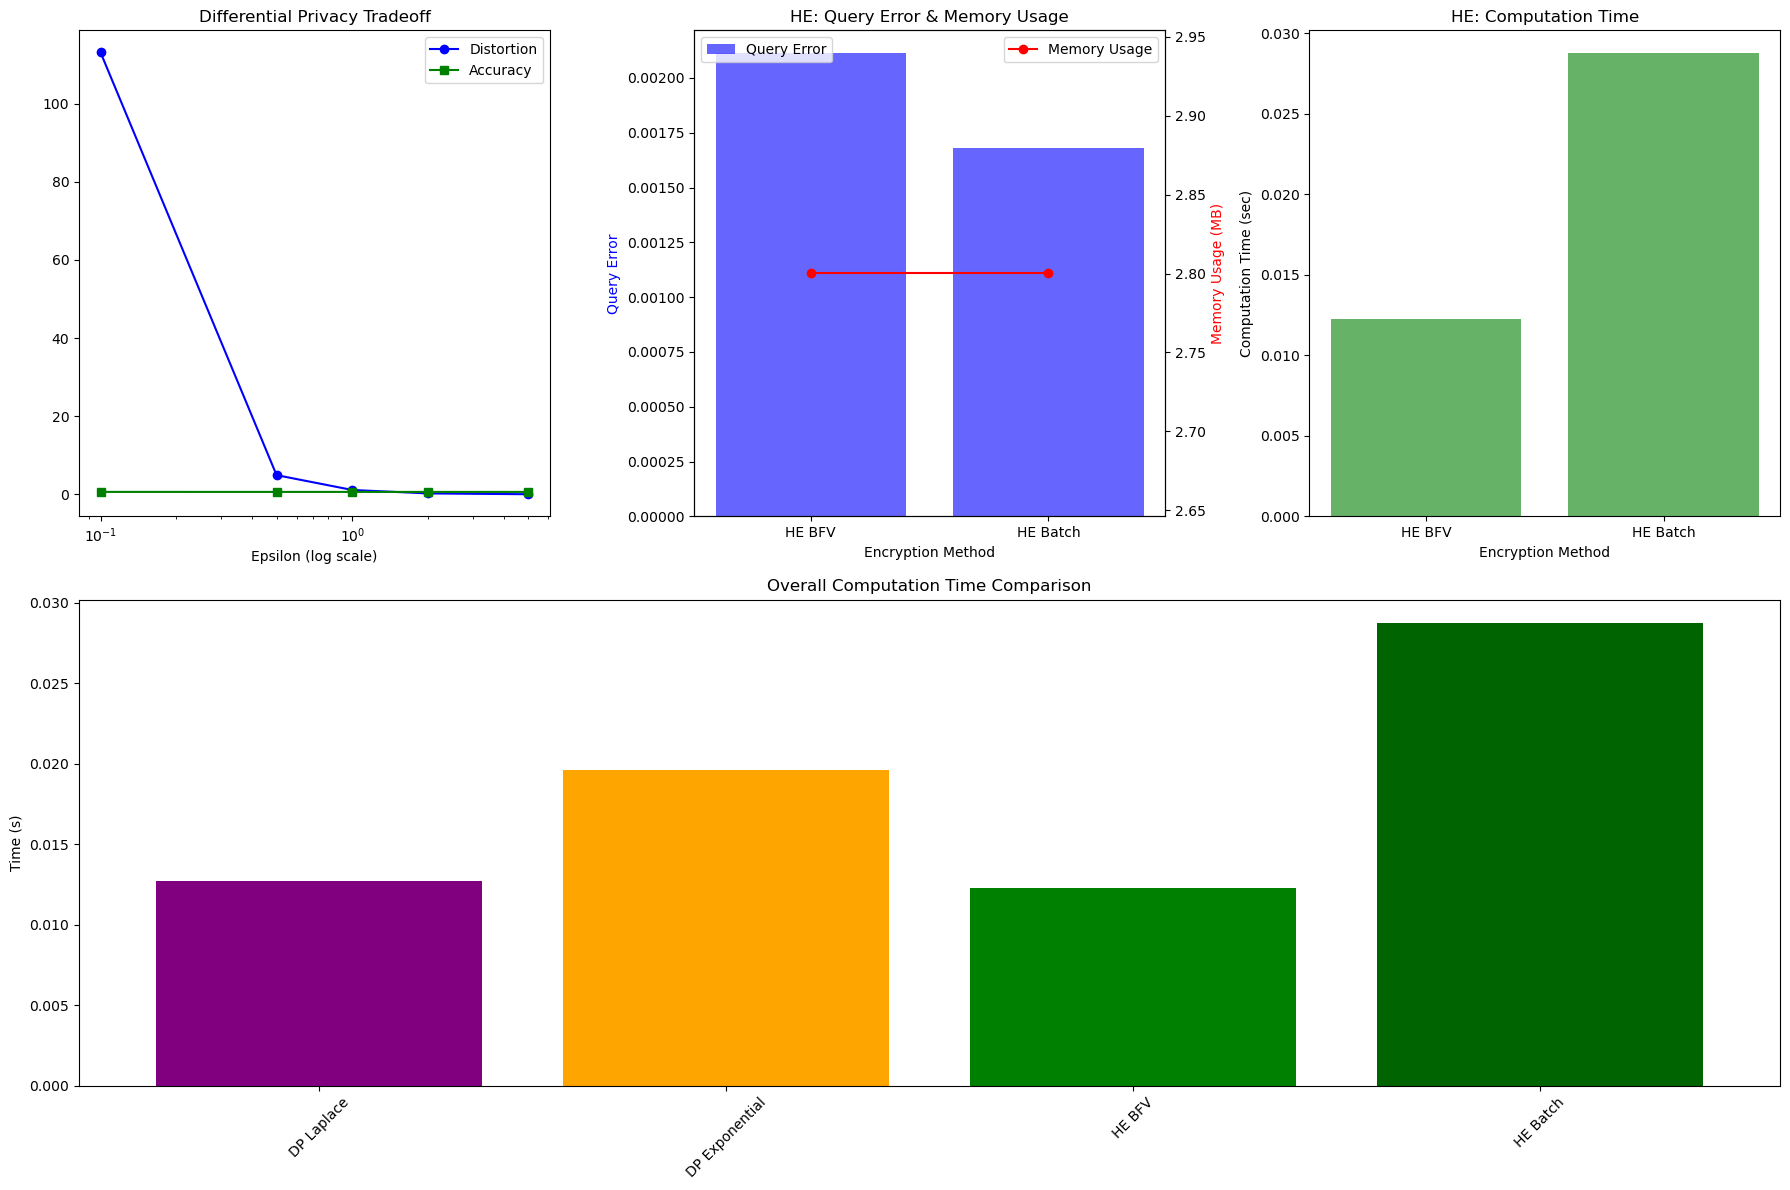

In [39]:
# main
if __name__ == "__main__":
    evaluator = PrivacyUtilitySystem()
    
    # For full-scale evaluation (requires 32GB+ RAM)
    # results = evaluator.run_evaluation()
    
    # For testing with 1M samples
    results = evaluator.run_evaluation(sample_size = 100000)

In [25]:
# displaying data after DP and HE applied

evaluator = PrivacyUtilitySystem()
comparison_df = evaluator.get_data_comparison()
print(comparison_df)

        Original                         DP Protected                         \
   Trip Distance Fare Amount Passengers Trip Distance Fare Amount Passengers   
0       4.741786    9.572042        1.0          4.41   10.090000        1.0   
1       3.154339   12.556005        2.0          2.70   13.430000        2.0   
2       5.119221   10.220951        1.0          4.12   10.120000        1.0   
3       7.307575   15.883345        4.0          7.28   10.680000        4.0   
4       2.914617   24.577429        3.0          2.02   27.299999        3.0   
..           ...         ...        ...           ...         ...        ...   
95      0.158787   27.792986        3.0          1.06   28.850000        3.0   
96      4.240301   20.385069        4.0          1.51   19.920000        4.0   
97      4.152638   17.440683        4.0         10.29   18.420000        4.0   
98      3.512784   11.799043        4.0          2.15    9.810000        4.0   
99      2.913532   10.334674        4.0 